In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

!unzip cats_and_dogs_filtered.zip

--2024-10-26 13:02:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.207, 142.250.153.207, 142.250.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M  29.2MB/s    in 2.2s    

2024-10-26 13:02:52 (29.2 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

# 다운 받은 데이터 path를 만들어 두고요,
PATH = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

# train과 validation 폴더 이름도 정해주고요.
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# image_dataset_from_directory를 이용하면 batch size와 image size에 맞춰서 자동으로 나눠줍니다. 너무 멋쟁이! 단, tf2.3이상이어야 되는 것 같아요.
# Batch size는 32, Image Size는 160x160입니다.
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

# Test dataset을 validation dataset에서 가져와봐요~ 20%정도? (그래서 //5로 연산합니다)
size_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(size_batches // 5)
validation_dataset = validation_dataset.skip(size_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


['cats', 'dogs']
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(0, shape=(), dtype=int32)
0
0
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(1, shape=(), dtype=int32)
1
1
0
tf.Tensor(1, shap

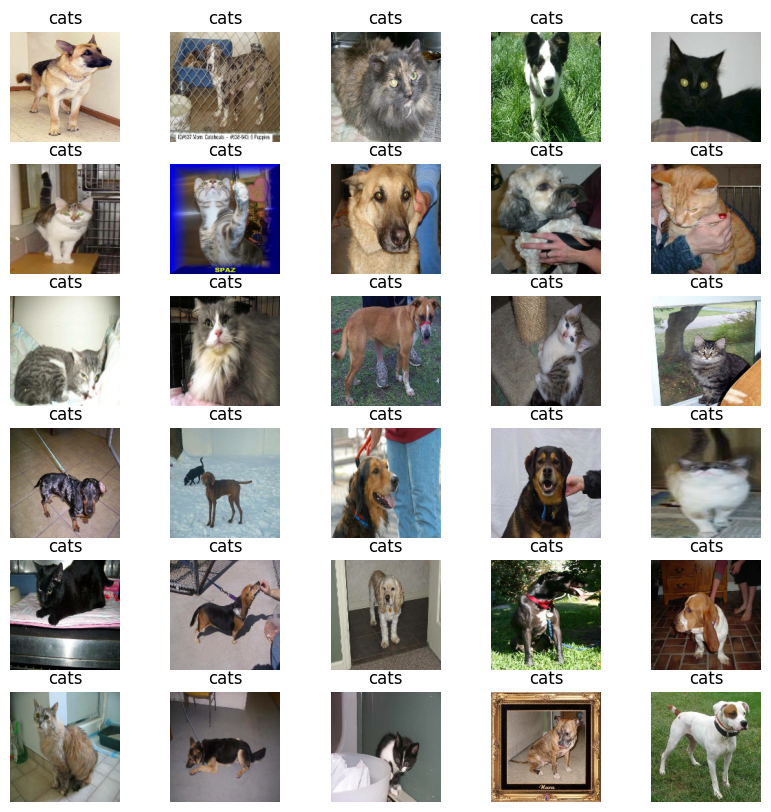

In [ ]:
plt.figure(figsize=(10, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1): # 이렇게 하면 single batch를 가져올 수 있습니다. 헤헿
    for i in range(30): # 32개이지만, 그냥 30개만 봐요.
        ax = plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
layer_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
layer_monet_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
layer_rescale = tf.keras.layers.Rescaling(1./127.5, offset= -1)

In [ ]:
IMG_SHAPE = (160 , 160 , 3)
model_base = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
model_base.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
output_batch = model_base(image_batch)
print(output_batch.shape)

(32, 5, 5, 1280)


In [ ]:
layer_global_average = tf.keras.layers.GlobalAveragePooling2D()
output_batch_average = layer_global_average(output_batch)
print(output_batch_average.shape)

(32, 1280)


In [ ]:
layer_out_fully_connected = tf.keras.layers.Dense(1)
prediction_on_batch_out = layer_out_fully_connected(output_batch_average)
print(prediction_on_batch_out.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = layer_augmentation(inputs)
x = layer_monet_input(x)
x = model_base(x)
x = layer_global_average(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = layer_out_fully_connected(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
first_step_epochs = 10
history = model.fit(train_dataset,
                    epochs=first_step_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6776 - loss: 0.5761 - val_accuracy: 0.8280 - val_loss: 0.3764
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.7757 - loss: 0.4435 - val_accuracy: 0.8762 - val_loss: 0.2860
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8217 - loss: 0.3631 - val_accuracy: 0.9059 - val_loss: 0.2301
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8502 - loss: 0.3033 - val_accuracy: 0.9307 - val_loss: 0.1935
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8927 - loss: 0.2598 - val_accuracy: 0.9332 - val_loss: 0.1686
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8805 - loss: 0.2516 - val_accuracy: 0.9493 - val_loss: 0.1516
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8920 - loss: 0.2286 - val_accuracy: 0.9493 - val_loss: 0.1408
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9095 - loss: 0.2171 - val_accuracy: 0.9542 - val_loss:

In [ ]:
# base model에 얼마나 많은 layer가 있는지 확인해 보고요,
print("Number of layers in the base model: ", len(model_base.layers))

# 바로 전에는 mobile net을 아예 학습에 참여시키지 않았지만, 이번엔 뒤쪽 100개 layer는 학습에 참여시킬 셈입니다. 일단 모형 전체를 trainable로 세팅 해 주고요.
model_base.trainable = True

# 100개 Fine tuning 시작점을 정해주고요,
fine_tune_at = 100

# 0~100까지는 freeze시켜서는 학습에 참여하지 않도록 해 줍니다.
for layer in model_base.layers[:fine_tune_at]:
  layer.trainable =  False

# 한번 봅시다. 실제로 trainable이 잘 세팅 되었는지 말이죠.
import pandas as pd
display_layers = [(layer, layer.name, layer.trainable) for layer in model_base.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Number of layers in the base model:  154


,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer, built=True>",input_layer,False
1,"<Conv2D name=Conv1, built=True>",Conv1,False
2,"<BatchNormalization name=bn_Conv1, built=True>",bn_Conv1,False
3,"<ReLU name=Conv1_relu, built=True>",Conv1_relu,False
4,"<DepthwiseConv2D name=expanded_conv_depthwise,...",expanded_conv_depthwise,False
...,...,...,...
149,"<Conv2D name=block_16_project, built=True>",block_16_project,True
150,"<BatchNormalization name=block_16_project_BN, ...",block_16_project_BN,True
151,"<Conv2D name=Conv_1, built=True>",Conv_1,True
152,"<BatchNormalization name=Conv_1_bn, built=True>",Conv_1_bn,True


In [ ]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 10 epoch동안 추가로 fine-tuning 진행해 보시죠.
fine_tune_epochs = 10
total_epochs =  first_step_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.8283 - loss: 0.4066 - val_accuracy: 0.9777 - val_loss: 0.0780
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9004 - loss: 0.2594 - val_accuracy: 0.9752 - val_loss: 0.0715
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9137 - loss: 0.2014 - val_accuracy: 0.9814 - val_loss: 0.0595
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9180 - loss: 0.1923 - val_accuracy: 0.9814 - val_loss: 0.0506
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9333 - loss: 0.1663 - val_accuracy: 0.9839 - val_loss: 0.0513
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9401 - loss: 0.1501 - val_accuracy: 0.9851 - val_loss: 0.0426
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9217 - loss: 0.1594 - val_accuracy: 0.9814 - val_loss: 0.0477
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9519 - loss: 0.1283 - val_accuracy: 0.98